In [1]:
import numpy as np
import os
import pickle
import json
import matplotlib.pyplot as plt
from surface_level_analyses import LexicalSurfaceLevelAnalysis
import random
import torch
from mauve import compute_mauve

## Step One: Combine the intermediate computations

In [2]:
CACHE_FOLDER = '/home/mog29/cogen/paper_analysis/analysis_cache/intermediate_language_computations'
TREATMENTS = ['full', 'no_ji', 'no_ds', 'baseline', 'human']

# Initialize the dict
treatment_to_results = {}
for treatment in TREATMENTS:
    treatment_to_results[treatment] = {}

    start_idx = 2 if treatment in ['no_ds', 'baseline'] else 1
    for i in range(start_idx, 5):
        treatment_to_results[treatment][i] = []

# Load the intermediate computations
for i in range(32):
    path = os.path.join(CACHE_FOLDER, f'intermediate_{i}.pkl')
    with open(path, 'rb') as f:
        intermediates = pickle.load(f)

    for treatment, treatment_dict in intermediates.items():
        for deployment_round, round_list in treatment_dict.items():
            treatment_to_results[treatment][deployment_round].extend(round_list)

In [3]:
# Extract the individual results

def extract_vocab_size_dict(treatment_to_results):
    vocab_sizes = {}
    for treatment in TREATMENTS:
        vocab_sizes[treatment] = {}
        start_idx = 2 if treatment in ['no_ds', 'baseline'] else 1
        for deployment_round in range(start_idx, 5):
            vocab_sizes[treatment][deployment_round] = [outputs[1] for outputs in treatment_to_results[treatment][deployment_round]]
    return vocab_sizes
treatment_to_vocab = extract_vocab_size_dict(treatment_to_results)

def extract_utterance_dict(treatment_to_results):
    utterance_lens = {}
    for treatment in TREATMENTS:
        utterance_lens[treatment] = {}
        start_idx = 2 if treatment in ['no_ds', 'baseline'] else 1
        for deployment_round in range(start_idx, 5):
            utterance_lens[treatment][deployment_round] = [outputs[0] for outputs in treatment_to_results[treatment][deployment_round]]
    return utterance_lens
treatment_to_utterance_lens = extract_utterance_dict(treatment_to_results)

def extract_new_words_dict(treatment_to_results):
    new_words = {}
    for treatment in ['full', 'no_ds', 'no_ji', 'baseline']:
        new_words[treatment] = {}
        for deployment_round in range(2, 5):
            new_words[treatment][deployment_round] = [outputs[2] for outputs in treatment_to_results[treatment][deployment_round]]
    return new_words
treatment_to_new_words = extract_new_words_dict(treatment_to_results)

def extract_mauve_dict(treatment_to_results):
    mauves = {}
    for treatment in ['full', 'no_ds', 'no_ji', 'baseline']:
        mauves[treatment] = {}
        start_idx = 2 if treatment in ['no_ds', 'baseline'] else 1
        for deployment_round in range(start_idx, 5):
            mauves[treatment][deployment_round] = [outputs[3] for outputs in treatment_to_results[treatment][deployment_round]]
    return mauves
treatment_to_mauves = extract_mauve_dict(treatment_to_results)
    

## Utterance Length and Vocabulary Size

full
Length:  [9.73, 8.51, 8.53, 7.53]

no_ji
Length:  [10.37, 8.27, 7.43, 7.7]

no_ds
Length:  [9.73, 9.61, 9.06, 9.33]

baseline
Length:  [10.37, 9.62, 9.56, 9.35]

human
Length:  [11.02, 9.84, 8.9, 8.12]



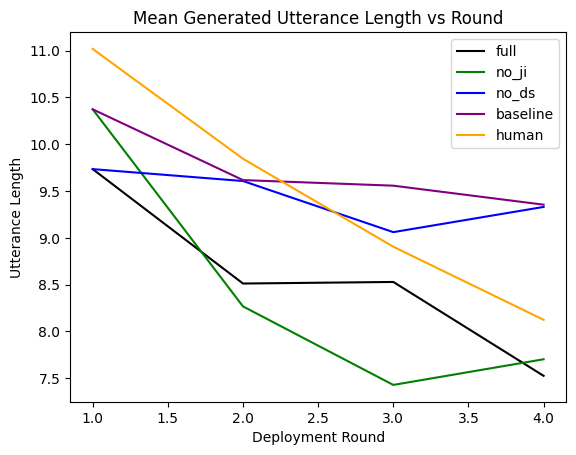

In [4]:
# Utterance length

plt.title('Mean Generated Utterance Length vs Round')
plt.xlabel('Deployment Round')
plt.ylabel('Utterance Length')

treatment_to_color = {
    'full' : 'black', 'no_ji' : 'green', 'no_ds' : 'blue', 'baseline' : 'purple', 'human' : 'orange'
}

TREATMENTS = ['full', 'no_ji', 'no_ds', 'baseline']
for treatment in TREATMENTS + ["human"]:
    x = list(range(1, 5))
    color = treatment_to_color[treatment]

    lengths = []
    for i in x:
        curr_treatment = treatment
        if i == 1 and treatment in ['no_ds', 'baseline']:
            curr_treatment = 'full' if treatment == 'no_ds' else 'no_ji'
        utt_lengths = treatment_to_utterance_lens[curr_treatment][i]
        mean_len = np.mean(utt_lengths)
        lengths.append(mean_len)

    plt.plot(x, lengths, color=color, label=treatment)

    print(treatment)
    print('Length: ', [round(length, 2) for length in lengths])
    print()

plt.legend()
plt.show()

full
Vocab Size:  [670.0, 719.5, 668.05, 629.35]

no_ji
Vocab Size:  [643.0, 603.61, 561.31, 606.2]

no_ds
Vocab Size:  [670.0, 639.87, 593.73, 596.68]

baseline
Vocab Size:  [643.0, 546.82, 507.91, 509.46]

human
Vocab Size:  [1429.0, 1333.26, 1192.03, 1234.2]



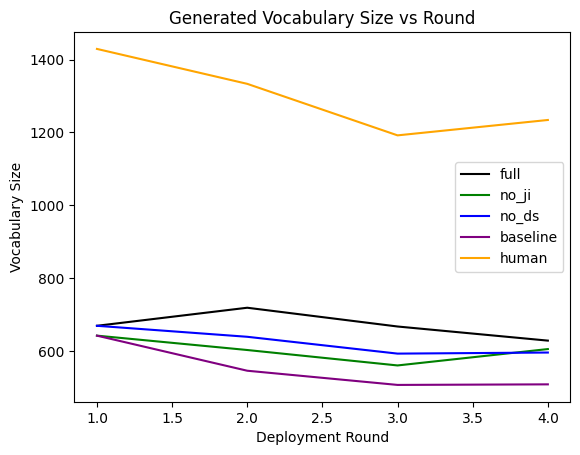

In [5]:
plt.title('Generated Vocabulary Size vs Round')
plt.xlabel('Deployment Round')
plt.ylabel('Vocabulary Size')

for treatment in TREATMENTS + ['human']:
    x = list(range(1, 5))
    color = treatment_to_color[treatment]

    vocab_sizes = []
    for i in x:
        curr_treatment = treatment
        if i == 1 and treatment in ['no_ds', 'baseline']:
            curr_treatment = 'full' if treatment == 'no_ds' else 'no_ji'
        vocab_size = treatment_to_vocab[curr_treatment][i]
        mean_size = np.mean(vocab_size)
        vocab_sizes.append(mean_size)

    plt.plot(x, vocab_sizes, color=color, label=treatment)

    print(treatment)
    print('Vocab Size: ', [round(size, 2) for size in vocab_sizes])
    print()

plt.legend()
plt.show()

full
Number of added words:  [261.63, 123.39, 83.36]

no_ji
Number of added words:  [177.23, 85.84, 77.12]

no_ds
Number of added words:  [177.65, 101.19, 71.56]

baseline
Number of added words:  [112.64, 44.84, 22.31]



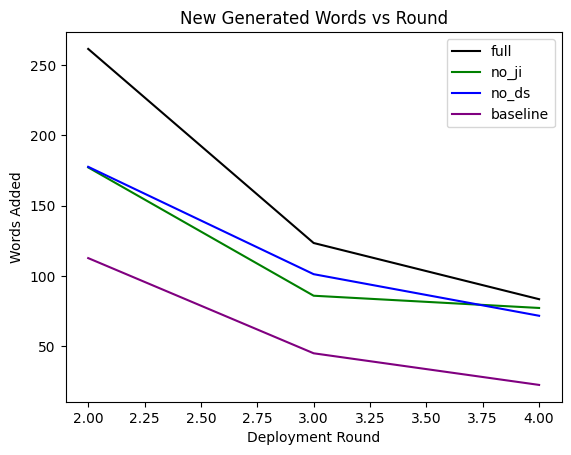

In [6]:
plt.title('New Generated Words vs Round')
plt.xlabel('Deployment Round')
plt.ylabel('Words Added')

for treatment in TREATMENTS:
    x = list(range(2, 5))
    color = treatment_to_color[treatment]

    num_added = []
    for i in x:
        nums_added = treatment_to_new_words[treatment][i]
        mean_added = np.mean(nums_added)
        num_added.append(mean_added)

    plt.plot(x, num_added, color=color, label=treatment)
    print(treatment)
    print('Number of added words: ', [round(added, 2) for added in num_added])
    print()

plt.legend()
plt.show()

full
MAUVE:  [0.4984965591144429, 0.5525736543595811, 0.5608109301483083, 0.5882176391555681]

no_ji
MAUVE:  [0.48773467775025914, 0.5108228689480279, 0.44057989339341785, 0.5500108604265442]

no_ds
MAUVE:  [0.4984965591144429, 0.3650743953759613, 0.30702839268518156, 0.3522706214712616]

baseline
MAUVE:  [0.48773467775025914, 0.23137353774913827, 0.2121743867324888, 0.1825681765052514]



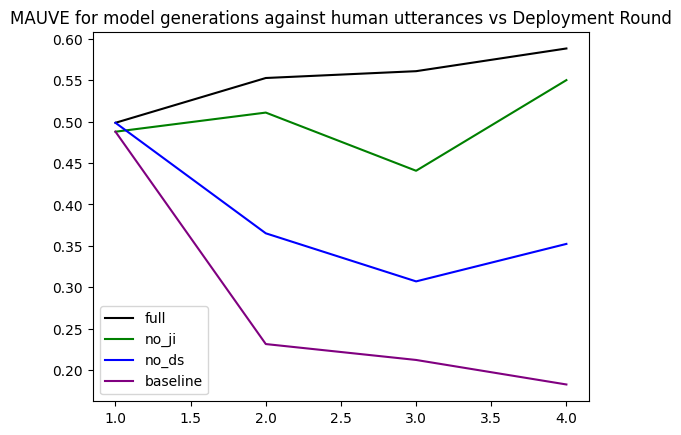

In [7]:
for treatment in TREATMENTS:
    x = list(range(1, 5))
    mauves = []
    for i in x:
        curr_treatment = treatment
        if i == 1 and treatment in ['no_ds', 'baseline']:
            curr_treatment = 'full' if treatment == 'no_ds' else 'no_ji'
        all_mauves = treatment_to_mauves[curr_treatment][i]
        mauve = np.mean(all_mauves)
        mauves.append(mauve)

    plt.plot(x, mauves, color=treatment_to_color[treatment], label=treatment)
    print(treatment)
    print('MAUVE: ', mauves)
    print()

plt.title("MAUVE for model generations against human utterances vs Deployment Round")
plt.legend()
plt.show()